In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Sequential
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy
from tensorflow.keras.activations import sigmoid
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

2023-05-14 13:05:19.812325: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def create_coffee_dataset():
    """
    Copied from lab_coffee_utils
    """
    rng = np.random.default_rng(2)
    X = rng.random(400).reshape(-1,2)
    X[:,1] = X[:,1] * 4 + 11.5          # 12-15 min is best
    X[:,0] = X[:,0] * (285-150) + 150  # 350-500 F (175-260 C) is best
    Y = np.zeros(len(X))
    
    i=0
    for t,d in X:
        y = -3/(260-175)*t + 21
        if (t > 175 and t < 260 and d > 12 and d < 15 and d<=y ):
            Y[i] = 1
        else:
            Y[i] = 0
        i += 1

    return (X, Y.reshape(-1,1))

In [3]:
def sigmoid(z):
    z = np.clip( z, -500, 500 ) #protect against overflow
    return 1 / (1 + np.exp(-z))

def init_weights(weights_amount, neurons_amount, randomize = False):
    '''
    Params:
        weights_amount  : how many weights do we have for one neuron, equals to amount of inputs
        neurons_amount  : how many neurons do we have in a layer
    Returns:
        [M x N] matrix of ones or randoms, where
            M (row count): the amount of neurons
            N (col count): the amount of weighs
    '''
    size = (neurons_amount, weights_amount)
    return np.random.default_rng().standard_normal(size) if randomize else np.ones(size)

def init_biases(neurons_amount, randomize = False):
    size = (neurons_amount, 1)
    return np.random.default_rng().standard_normal(size) if randomize else np.ones(size)

def execute_layer(W, b, a_in):
    function_input = np.matmul(W, a_in) + b
    function_out = sigmoid(function_input)
    return function_out

In [4]:
W1_tmp = np.array( [[-8.93,  0.29, 12.9 ], [-0.1,  -7.32, 10.81]] )
b1_tmp = np.array( [-9.82, -9.28,  0.96] )[:, np.newaxis]
W2_tmp = np.array( [[-31.18], [-27.59], [-32.56]] )
b2_tmp = np.array( [15.41] )[:, np.newaxis]

In [5]:
X,Y = create_coffee_dataset()

# Create normalization layer
# Can be used to normalized other values, not from existing dataset
norm_l = tf.keras.layers.Normalization(axis=-1)
norm_l.adapt(X)
# Xn = norm_l(X)


X_tst = np.array([
    [200,13.9],  # postive example
    [200,17] # negative example
])   

sample_data = norm_l(X_tst).numpy()  # normalize and convert to numpy

2023-05-14 13:05:23.002161: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
layer_1 = execute_layer(W1_tmp.T, b1_tmp, sample_data.T)
layer_2 = execute_layer(W2_tmp.T, b2_tmp, layer_1)

print(layer_1)
print()
print(layer_2)

[[3.36822650e-03 2.56119674e-03]
 [3.87912190e-06 7.16559036e-15]
 [3.61185670e-01 1.00000000e+00]]

[[9.71932288e-01 3.28978626e-08]]


In [7]:
def predict(X_norm, W1, b1, W2, b2):
    layer_1 = execute_layer(W1.T, b1, X_norm.numpy().T)
    layer_2 = execute_layer(W2.T, b2, layer_1)
    return layer_2[:, :]

# predict(sample_data, W1_tmp, b1_tmp, W2_tmp, b2_tmp)

In [8]:
predictions = layer_2[0, :] # Take the first row, since the result of the prediction model is a vector anyway

yhat = np.zeros_like(predictions)
for i in range(len(predictions)):
    if predictions[i] >= 0.5:
        yhat[i] = 1
    else:
        yhat[i] = 0
print(f"decisions = \n{yhat}")

yhat = (predictions >= 0.5).astype(int)
print(f"decisions = \n{yhat}")

decisions = 
[1. 0.]
decisions = 
[1 0]


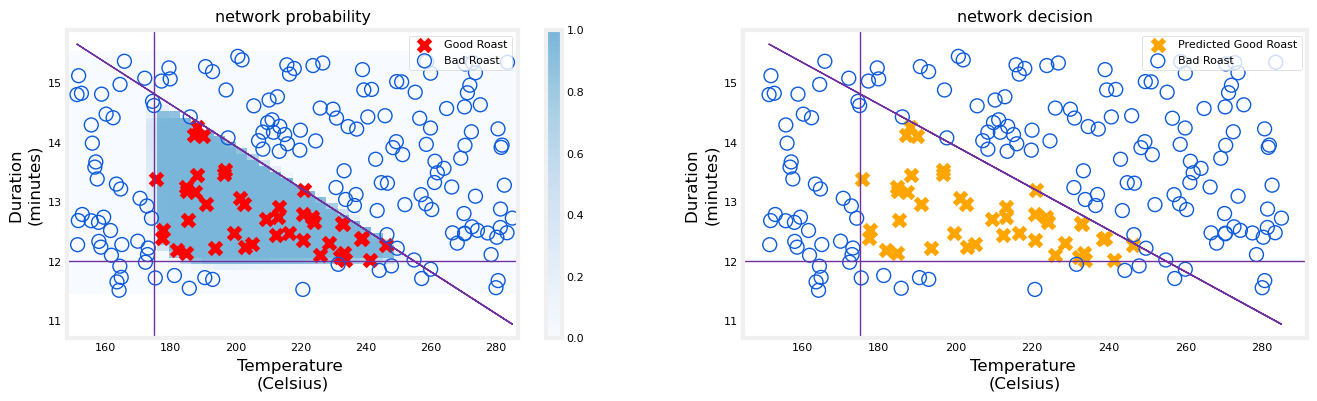

In [9]:
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)
plt.style.use('./deeplearning.mplstyle')

from lab_coffee_utils import load_coffee_data, plt_roast, plt_prob, plt_layer, plt_network, plt_output_unit

netf = lambda x : predict(norm_l(x),W1_tmp, b1_tmp, W2_tmp, b2_tmp)
plt_network(X,Y,netf)